Recommendation systems and Clustering


### Data Preprocessing


In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
from itertools import permutations
import warnings
from datasketch import MinHash, MinHashLSH
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#open data
df = pd.read_csv('vodclickstream_uk_movies_03.csv')
df = df.rename(columns={'Unnamed: 0': 'row_id'})
df.head()

,row_id,datetime,duration,title,genres,release_date,movie_id,user_id
0,58773,2017-01-01 01:15:09,0.0,"Angus, Thongs and Perfect Snogging","Comedy, Drama, Romance",2008-07-25,26bd5987e8,1dea19f6fe
1,58774,2017-01-01 13:56:02,0.0,The Curse of Sleeping Beauty,"Fantasy, Horror, Mystery, Thriller",2016-06-02,f26ed2675e,544dcbc510
2,58775,2017-01-01 15:17:47,10530.0,London Has Fallen,"Action, Thriller",2016-03-04,f77e500e7a,7cbcc791bf
3,58776,2017-01-01 16:04:13,49.0,Vendetta,"Action, Drama",2015-06-12,c74aec7673,ebf43c36b6
4,58777,2017-01-01 19:16:37,0.0,The SpongeBob SquarePants Movie,"Animation, Action, Adventure, Comedy, Family, ...",2004-11-19,a80d6fc2aa,a57c992287


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671736 entries, 0 to 671735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   row_id        671736 non-null  int64  
 1   datetime      671736 non-null  object 
 2   duration      671736 non-null  float64
 3   title         671736 non-null  object 
 4   genres        671736 non-null  object 
 5   release_date  671736 non-null  object 
 6   movie_id      671736 non-null  object 
 7   user_id       671736 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 41.0+ MB


#### Top 10 movies that each user clicked on regarding the number of clicks



In [4]:
df_clicks = df.groupby(['user_id', 'movie_id']).size().reset_index(name='number_of_clicks')

if 'title' in df.columns and 'genres' in df.columns:
    df_clicks = df_clicks.merge(df[['movie_id', 'title', 'genres']].drop_duplicates(), on='movie_id', how='left')

#filtering users with too small data
user_movie_counts = df_clicks.groupby("user_id")["movie_id"].count()

valid_users = user_movie_counts[user_movie_counts >= 3].index

df_clicks_filtered = df_clicks[df_clicks["user_id"].isin(valid_users)]

#sorting
df_clicks_sorted = df_clicks_filtered.sort_values(['user_id', 'number_of_clicks'], ascending=[True, False])
df_top_10 = df_clicks_sorted.groupby('user_id').head(10)

df_top_10.head(10)  # Print first 10 rows for preview 


,user_id,movie_id,number_of_clicks,title,genres
2,000052a0a0,4718f9963c,9,Looper,"Action, Drama, Sci-Fi, Thriller"
3,000052a0a0,4fa0b092d6,3,Jumanji,"Adventure, Comedy, Family, Fantasy"
6,000052a0a0,7314699c23,3,Frailty,"Crime, Drama, Thriller"
5,000052a0a0,6275614f9a,2,Resident Evil,"Action, Horror, Sci-Fi"
1,000052a0a0,43bb6de314,1,Green Room,"Horror, Music, Thriller"
4,000052a0a0,59d313ed8b,1,Ant-Man,"Action, Adventure, Comedy, Sci-Fi"
7,000052a0a0,96debad268,1,The SpongeBob Movie: Sponge Out of Water,"Animation, Action, Adventure, Comedy, Family, ..."
8,000052a0a0,cccedbafeb,1,Resident Evil: Retribution,"Action, Horror, Sci-Fi, Thriller"
9,000052a0a0,d601124c11,1,The Big Lebowski,"Comedy, Crime, Sport"
10,000052a0a0,f254d41c3d,1,The Nice Guys,"Action, Comedy, Crime, Mystery, Thriller"


C:\Users\Utente\AppData\Local\Temp\ipykernel_31632\1665990091.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')


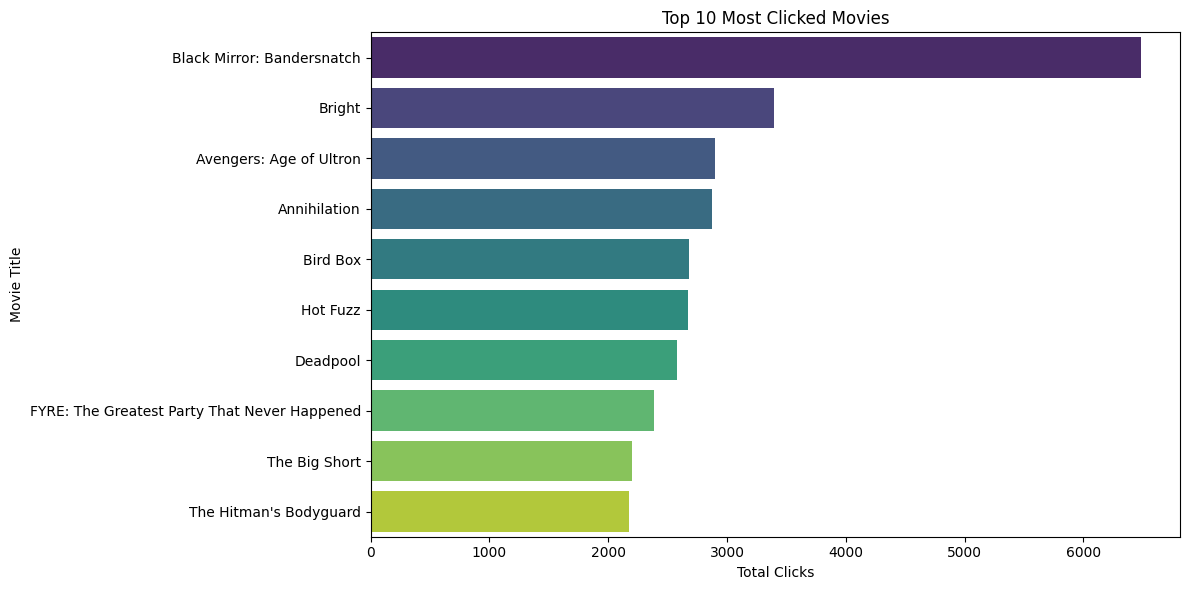

In [5]:
top_movies = df_clicks.groupby('title')['number_of_clicks'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index, palette='viridis')
plt.title("Top 10 Most Clicked Movies")
plt.xlabel("Total Clicks")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

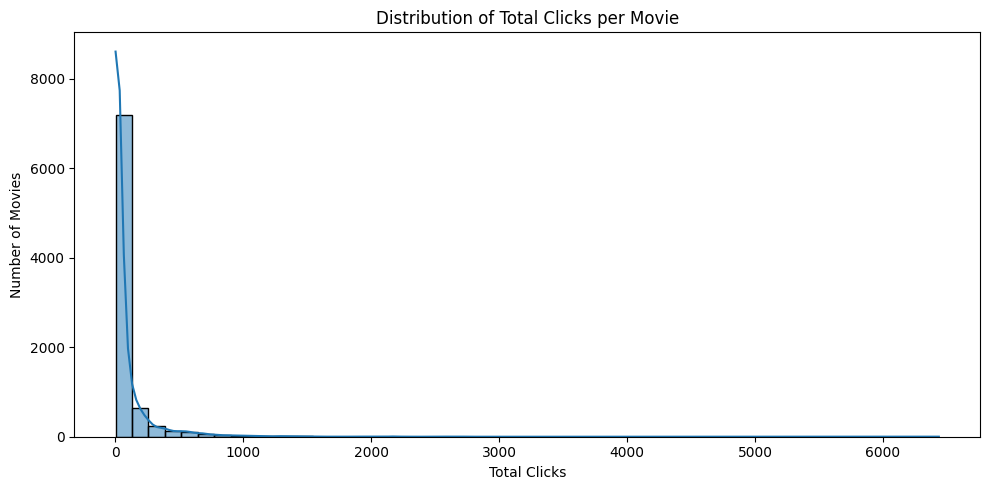

In [6]:
movie_clicks = df_clicks.groupby('movie_id')['number_of_clicks'].sum()

plt.figure(figsize=(10, 5))
sns.histplot(movie_clicks, bins=50, kde=True)
plt.title("Distribution of Total Clicks per Movie")
plt.xlabel("Total Clicks")
plt.ylabel("Number of Movies")
plt.tight_layout()
plt.show()

In [15]:
# top 10 movies for all users as a list

top10_per_user = df_top_10.groupby('user_id').agg(top_movies=('title', list), top_genres=('genres', list)).reset_index()
top10_per_user.head()

,user_id,top_movies,top_genres
0,000052a0a0,"[Looper, Jumanji, Frailty, Resident Evil, Gree...","[Action, Drama, Sci-Fi, Thriller, Adventure, C..."
1,0002aab109,"[127 Hours, King Cobra, The Iron Lady]","[Biography, Drama, Comedy, Crime, Drama, Biogr..."
2,0005c8fbac,"[The Purge, In Bruges, Shrek, Jaws]","[Horror, Thriller, Comedy, Crime, Drama, Thril..."
3,0006ea6b5c,"[Dragon Blade, Shimmer Lake, Okja, War Machine...","[Action, Adventure, Drama, Fantasy, History, C..."
4,000a3ec774,"[Valentine's Day, ROMA, The Bookshop]","[Comedy, Romance, Drama, Drama]"


### Minhash Signatures

Using the movie genre and user_ids, implement your min-hash signatures so that users with similar interests in a genre appear in the same bucket

In [18]:
# create Minhash signatures
def compute_minhash(movie_list, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for movie in movie_list:
        m.update(movie.encode('utf8'))
    return m

# apply Minhash to users
top10_per_user["minhash"] = top10_per_user["top_movies"].apply(lambda x: compute_minhash(x))

### Locality-Sensitive Hashing (LSH)

In [30]:
# create LSH with 10 groups (b=10)
lsh = MinHashLSH(threshold=0.2, num_perm=128)

# Add users to LSH
for index, row in top10_per_user.iterrows():
    lsh.insert(str(row["user_id"]), row["minhash"])

In [31]:
def recommend_movies(user_id):
    user_id = str(user_id)

    # get the user's row
    user_row = top10_per_user[top10_per_user["user_id"].astype(str) == user_id]
    if user_row.empty:
        return []

    # get user's MinHash
    user_minhash = user_row["minhash"].values[0]
    similar_users = lsh.query(user_minhash)

    # get user's own movies
    user_movies = set(user_row["top_movies"].values[0])
    recommended_movies = set()

    for similar_user in similar_users:
        if similar_user == user_id:
            continue
        similar_movies = set(
            top10_per_user[top10_per_user["user_id"].astype(str) == similar_user]["top_movies"].values[0]
        )
        recommended_movies.update(similar_movies - user_movies)

    return list(recommended_movies)[:5]

In [32]:
# for ex user 0002aab109
print(top10_per_user.loc[top10_per_user["user_id"] == "000052a0a0", "top_movies"].values[0])
print(recommend_movies("000052a0a0"))

['Looper', 'Jumanji', 'Frailty', 'Resident Evil', 'Green Room', 'Ant-Man', 'The SpongeBob Movie: Sponge Out of Water', 'Resident Evil: Retribution', 'The Big Lebowski', 'The Nice Guys']
['The Grand Budapest Hotel', "You Don't Mess with the Zohan", 'Woman on Top', 'Ghostbusters II', 'Okja']


### Evaluating Recommendation quality using Jaccard similiarity

In [33]:
import random

def evaluate_recommendations(user_id, holdout_size=3, num_recommendations=5):
    user_row = top10_per_user[top10_per_user["user_id"] == user_id]
    if user_row.empty:
        return None
    
    movies = user_row["top_movies"].values[0]
    if len(movies) <= holdout_size:
        return None  # Not enough movies to split

    # Split into train/test
    test_set = set(random.sample(movies, holdout_size))
    train_set = set(movies) - test_set

    # Run recommender using only train set
    def recommend_from_subset(train_movies):
        m = compute_minhash(list(train_movies))
        similar_users = lsh.query(m)
        recs = set()
        for sim_user in similar_users:
            if sim_user == str(user_id):
                continue
            sim_movies = set(top10_per_user[top10_per_user["user_id"] == sim_user]["top_movies"].values[0])
            recs.update(sim_movies - train_movies)
        return list(recs)[:num_recommendations]

    recommended = set(recommend_from_subset(train_set))
    
    if not recommended:
        return 0

    return len(recommended & test_set) / len(recommended | test_set)

# Evaluate over a sample
precision_scores = []
for user in sampled_users:
    score = evaluate_recommendations(user)
    if score is not None:
        precision_scores.append(score)

# Report
if precision_scores:
    print(f"Users evaluated: {len(precision_scores)} / {len(sampled_users)}")
    print(f"Average Jaccard Similarity (train/test): {sum(precision_scores) / len(precision_scores):.4f}")
else:
    print("No users with enough data for evaluation.")


Users evaluated: 702 / 1000
Average Jaccard Similarity (train/test): 0.0050


#### Feature Engineering

In [ ]:
# function to calculate the favorite genre
def favorite_genre(users_df):
    return users_df.groupby('genres')['duration'].sum().idxmax()

# function to count total clicks
def total_clicks_count(users_df):
    return users_df.shape[0]

# function to count number of unique movies watched
def unique_movies_watched(users_df):
    return users_df['movie_id'].nunique()

# function to find the most watched movie
def favourite_movie(users_df):
    return users_df.groupby('movie_id')['duration'].sum().idxmax()

# function to find the most active month
def most_active_month(users_df):
    return users_df['datetime'].dt.month.mode()[0]

In [ ]:
df1 = df.copy()

# convert to datetime format
df1['datetime'] = pd.to_datetime(df1['datetime'])

# group by user_id
grouped = df1.groupby('user_id')

# calculate favorite genre
favorite_genre = grouped.apply(lambda x: x.groupby('genres')['duration'].sum().idxmax())

# calculate total clicks count
total_clicks_count = grouped.size()

# calculate number of unique movies watched
unique_movies_watched = grouped['movie_id'].nunique()

# calculate favorite movie
favourite_movie = grouped.apply(lambda x: x.groupby('movie_id')['duration'].sum().idxmax())

# calculate most active month
most_active_month = grouped['datetime'].apply(lambda x: x.dt.month.mode()[0])

# combine all features
user_features_df = pd.DataFrame({
    'favorite_genre': favorite_genre,
    'total_clicks_count': total_clicks_count,
    'number_of_unique_movies_watched': unique_movies_watched,
    'favourite_movie': favourite_movie,
    'most_active_month': most_active_month
}).reset_index()

In [ ]:
user_features_df.head()

,user_id,favorite_genre,total_clicks_count,number_of_unique_movies_watched,favourite_movie,most_active_month
0,00004e2862,Crime,3,1,9bfee795ff,12
1,000052a0a0,Action,92,11,f254d41c3d,6
2,000090e7c8,Mystery,3,1,eb72fbc6ee,3
3,000118a755,Horror,4,2,24c4c7425d,6
4,000296842d,Drama,32,1,e847f14da5,12
